In [1]:
#Installing fredapi
!pip install fredapi

In [2]:
#importing key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred

In [3]:
#setting up FRED key for DataSets
API_KEY = "02e4d3e26f092346d957b34deaca013a".strip()
fred = Fred(api_key=API_KEY)

In [5]:
#Defining FRED series ID for variables
series_dict = {
    "GILT10Y": "IRLTLT01GBM156N", #10-Year Gilt Yield (Long-Term Rate)
    "IR3M": "IR3TIB01GBM156N", #3-Month Interbank Lending Rate (Short-Term Rate) Proxy for 3-Month T-bill rate
    "CPI": "CPALTT01GBM659N", #CPI (Inflation Rate)
    "US_SPREAD": "BAMLH0A0HYM2" #US Spread as Proxy for UK Corporate Bond Spread
}

#fixing an invalidURL error i was receiving due to an attempt to fetch all items simultaneously, instead I am running a loop
data_container = {} #Store loop results
for col_name, fred_id in series_dict.items():
    series_data = fred.get_series(fred_id, observation_start="2018-01-01")
    data_container[col_name] = series_data
    print(f"Fetched:{col_name}")

#creating one comprehensive dataframe for all data
data = pd.DataFrame(data_container)

#check to see that this has been successful
print("\nData Acquisition Successful.")
print("--- First 5 rows of merged data: ---")
print(data.head())

Fetched:GILT10Y
Fetched:IR3M
Fetched:CPI
Fetched:US_SPREAD

Data Acquisition Successful.
--- First 5 rows of merged data: ---
            GILT10Y    IR3M  CPI  US_SPREAD
2018-01-01   1.3931  0.5225  2.7        NaN
2018-01-02      NaN     NaN  NaN       3.55
2018-01-03      NaN     NaN  NaN       3.48
2018-01-04      NaN     NaN  NaN       3.40
2018-01-05      NaN     NaN  NaN       3.36



Original rows: 2119. Final rows after cleaning: 56

--- Generating Charts. ---


C:\Users\inder\AppData\Local\Temp\ipykernel_3884\2847421315.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["YIELD_SLOPE"]= data_clean["GILT10Y"] - data_clean["IR3M"]
C:\Users\inder\AppData\Local\Temp\ipykernel_3884\2847421315.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["INFLATION_RATE"] = data_clean["CPI"].pct_change(periods=4) * 100
C:\Users\inder\AppData\Local\Temp\ipykernel_3884\2847421315.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

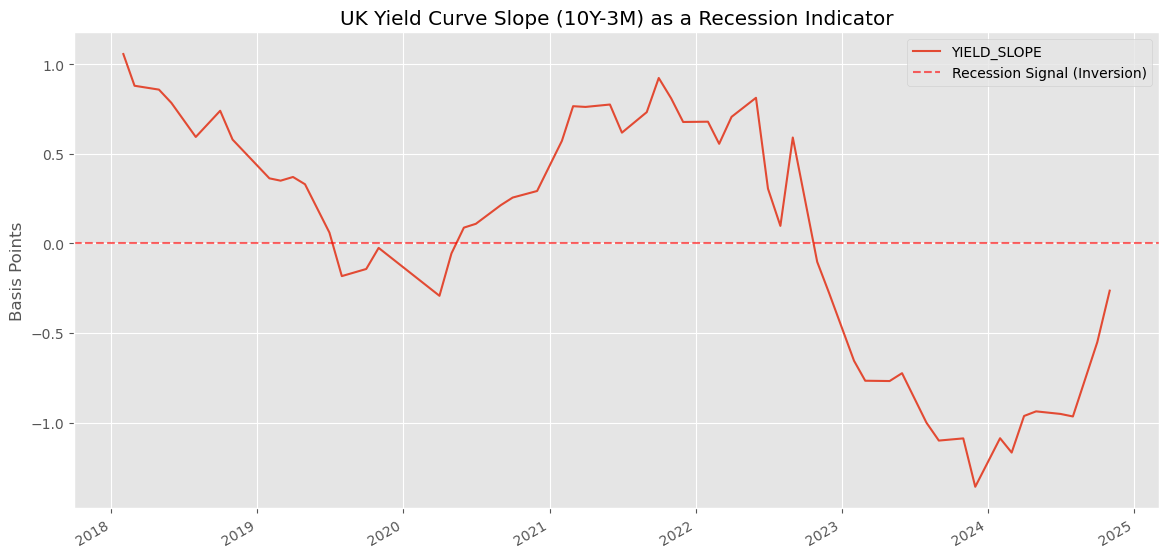

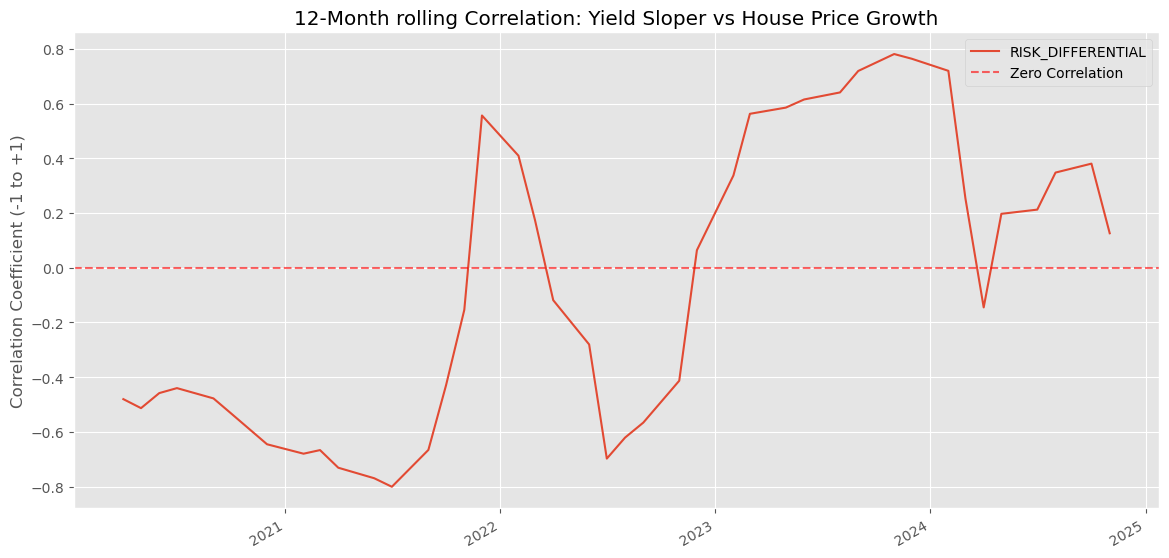

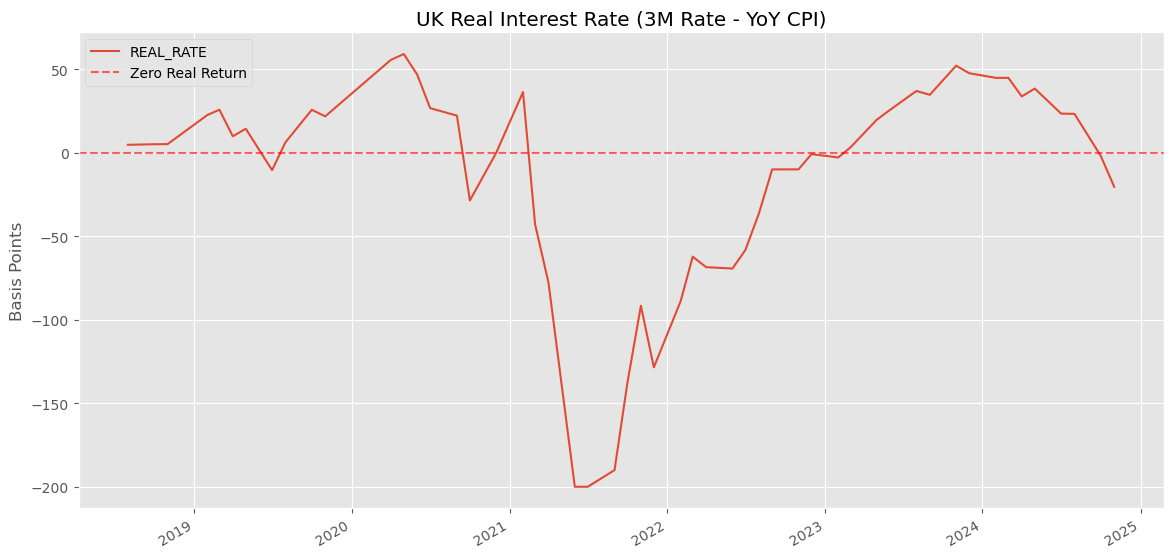

In [6]:
#Data Cleaning, Metric Calculation and Visualisation

#Data Cleaning. Dropping every row containing a missing value, should reduce dataset to quaterly frequency
data_clean = data.dropna()
print(f"\nOriginal rows: {len(data)}. Final rows after cleaning: {len(data_clean)}")

#Calculating ket metrics to be used for future analysis

#metric 1: Yield Curve SLope (Recession probability). Calculated by long term rate minus short term rate
data_clean["YIELD_SLOPE"]= data_clean["GILT10Y"] - data_clean["IR3M"]

#metric 2: Real Interest rate for Purchasing power/valuation risk
#Step 1: Convert CPI index level to a rate of inflation (YoY percentage change)
#Using periods = 4 to specify quarterly data instead of monthly data
data_clean["INFLATION_RATE"] = data_clean["CPI"].pct_change(periods=4) * 100

#Using inflation calculation, can now find real interest rate
data_clean["REAL_RATE"] = data_clean["IR3M"] - data_clean["INFLATION_RATE"]

#metric 3: Housing risk differeitatial (yield slope vs consumer wealth)
#Step 1: Calculate YoY house price growth as a proxy for wealth
#period =4
data_clean["HPI_YOY_GROWTH"] = data_clean["US_SPREAD"].pct_change(periods=4) * 100
#Step 2: create a rolling correlation between yield slope curve and house price growth, with a 12 month windwow, covering 3 years of data to analyse long term trends
data_clean["RISK_DIFFERENTIAL"] = data_clean["YIELD_SLOPE"].rolling(window=12).corr(data_clean["HPI_YOY_GROWTH"])

print("\n--- Generating Charts. ---")

#Visualisation
#3 pLots total
#Plot 1: Yield Curve slope as recession indicator
plt.style.use("ggplot")
plt.figure(figsize=(14,7))
data_clean["YIELD_SLOPE"].plot(title="UK Yield Curve Slope (10Y-3M) as a Recession Indicator")
plt.axhline(0, color="red", linestyle="--", alpha=0.6, label="Recession Signal (Inversion)")
plt.legend()
plt.ylabel("Basis Points")
plt.show()

#Plot 2, Housing risk differential for market stress
plt.figure(figsize=(14,7))
data_clean["RISK_DIFFERENTIAL"].plot(title="12-Month rolling Correlation: Yield Sloper vs House Price Growth")
plt.axhline(0, color="red", linestyle="--",alpha=0.6, label="Zero Correlation")
plt.legend()
plt.ylabel("Correlation Coefficient (-1 to +1)")
plt.show()

#Plot 3, Real Interest Rate as purchasing power indicator
plt.figure(figsize=(14,7))
data_clean["REAL_RATE"].plot(title="UK Real Interest Rate (3M Rate - YoY CPI)")
plt.axhline(0, color="red", linestyle="--", alpha=0.6, label="Zero Real Return")
plt.legend()
plt.ylabel("Basis Points")
plt.show()